# setup

In [167]:
import pandas as pd
import numpy as np


from datetime import timedelta

from warnings import filterwarnings
filterwarnings('ignore')
testing_models = True
# TODO:
# Add forecasting models that work
# use forecast instead of predict
# tune underperformers
# Determine when a forecasting model works given a time series features.



# data prep

In [168]:
data = pd.read_csv("../data/store_demand.csv")

In [169]:
data = pd.read_csv("../data/store_demand.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data['store_item'] = data.store.astype(str) + '-' + data.item.astype(str)
data.drop(['store', 'item'], axis=1, inplace=True)
# data = data[data.store_item != '3-5'] # auto reg broke on this one check it if time permits
# note non unique indices


# train test split

In [170]:
def train_test_splitter(df, pct=0.8):
    timespan = (df.index.max() - df.index.min()).days
    train_date = round(timespan*pct)
    train = df.index.min() + timedelta(days=train_date)
    return [df[df.index <= train], df[df.index > train]]


train, test = train_test_splitter(data, .7)



# time series feature detection

In [171]:
from tsfeatures import tsfeatures
# this function is kinda wierd it requires a df with specific names
n = 0
feature_list = []
for item in train.store_item.unique():
    
    tester = train[train.store_item == item]
    tester.reset_index(inplace=True)

    tester["unique_id"] = item
    tester.drop("store_item", axis=1, inplace=True)
    tester.rename(columns={"sales":"y", "date":"ds"}, inplace=True)

    features = tsfeatures(tester, freq=1)
    feature_list.append(features)
    n += 1
    if n > 5:
        break


arr = np.array(feature_list)
feats = arr.reshape(len(feature_list), 38)
pd.DataFrame(feats, columns=feature_list[0].columns)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,flat_spots,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
0,1-1,0.841606,1279,-991.917409,3.146563,NaN,NaN,NaN,0.436294,0,...,6,0.744548,419,0.117548,0.433635,1.498446,-0.433396,0.294302,-0.631182,0.535604
1,2-1,0.91135,1279,-831.494587,3.310794,NaN,NaN,NaN,0.489281,0,...,7,0.712613,407,0.142211,0.502687,1.879023,-0.429875,0.234543,-0.651916,0.499956
2,3-1,0.873043,1279,-987.775958,2.905416,NaN,NaN,NaN,0.456243,0,...,5,0.723574,429,0.091336,0.442316,1.617506,-0.462695,0.314891,-0.661656,0.592635
3,4-1,0.844694,1279,-1011.330434,2.582235,NaN,NaN,NaN,0.445286,0,...,7,0.739945,429,0.102222,0.435504,1.62504,-0.469077,0.28132,-0.656254,0.520351
4,5-1,0.860274,1279,-1180.265044,2.949875,NaN,NaN,NaN,0.378891,0,...,7,0.78065,493,0.045313,0.345667,1.045886,-0.474195,0.270755,-0.667555,0.541858
5,6-1,0.872302,1279,-1159.865159,2.517493,NaN,NaN,NaN,0.387035,0,...,7,0.78684,460,0.060444,0.351075,1.044682,-0.453832,0.252476,-0.638486,0.465


# plotting series

# tune models on a subset of categories

In [172]:

# subset for testing

if testing_models:
    train = train[train.store_item.isin(['1-1', '1-2', '1-3'])]
    test = test[test.store_item.isin(['1-1', '1-2', '1-3'])]
else: 
    from warnings import filterwarnings
    filterwarnings('ignore')
    

# Set forecast horizion

In [173]:
forecast_horizon = (train.shape[0] - test.shape[0]) / train.store_item.nunique()

In [174]:
import matplotlib.pyplot as plt

%matplotlib inline


# for store in train.store_item.unique():
#     temp = train[train.store_item == store]
#     plt.figure()
#     plt.plot(temp.sales, "-b", label = "sales")
#     plt.legend(loc="upper left")
#     plt.title(f"store {store}")
#     plt.show()


In [175]:
from statsmodels.tsa.ar_model import AutoReg

In [176]:
# generalize this a bit later, 
preds_autoreg = []
store_item = []
for series in train.store_item.unique(): 
    temp = train[train.store_item == series]
    
    model = AutoReg(temp.sales, lags=10, old_names=False, seasonal=True, period=365)
    model_fit = model.fit()
    try:
        yhat = model_fit.predict(len(temp), round((len(temp)*1/0.7) -2)) # find a less ratchet way
        # to make the prediction len match the testing set len
        preds_autoreg.append(yhat)
        item = np.repeat(series, len(yhat))
        store_item.append(item)
    except np.linalg.LinAlgError:
        print(f'series {series}')

In [177]:
dates = []
for item in preds_autoreg:
    for sub in item.index:
        dates.append(sub)

In [178]:
predictions = pd.DataFrame(
    {
        'store_item': [x for sub in store_item for x in sub],
        'sales': test.sales,
        'autoreg': [x for sub in preds_autoreg for x in sub]     
    }, index = dates
)

In [179]:
from statsmodels.tsa.arima.model import ARIMA

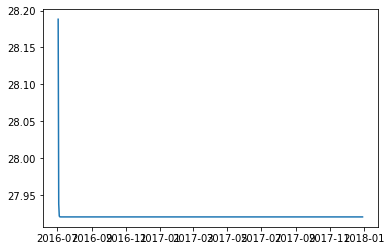

In [180]:
dat = train[train.store_item == "1-1"]
dat.index.freq = "d"

arima = ARIMA(dat.sales, order = (1, 1, 1))\
        .fit()\
        .forecast(steps = 546, alpha = 0.05)
plt.plot(arima)

In [181]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

In [182]:
exp_smooth_preds = []
for item in train.store_item.unique():
    temp = train[train.store_item == item]
    temp.index.freq = "d"
    preds = ExponentialSmoothing(temp.sales,     
        seasonal_periods=365,
        trend="add",
        seasonal="add",
        use_boxcox=True,
        initialization_method="estimated")\
    .fit()\
    .forecast(547)
    exp_smooth_preds.append(preds)
    
exp_smooth_preds
predictions["exp_smooth"] = [x for sub in exp_smooth_preds for x in sub]  

In [183]:
model = SimpleExpSmoothing(temp.sales, initialization_method="estimated")
predictions["sexpsmoothing"] = model_fitter(train, model)

In [184]:
model = ExponentialSmoothing(temp.sales)
predictions["expsmooth"] = model_fitter(train, model)

In [185]:
model = Holt(temp.sales, initialization_method="estimated")
predictions["holt"] = model_fitter(train, model)


In [186]:
store_sales = pd.concat([train, predictions])

In [187]:
predictions

,store_item,sales,autoreg,exp_smooth,sexpsmoothing,expsmooth,holt
2016-07-03,1-1,35,33.564926,34.968360,42.605203,42.605203,43.648692
2016-07-04,1-1,18,25.371284,27.868874,42.605203,42.605203,43.715954
2016-07-05,1-1,31,27.200800,26.861003,42.605203,42.605203,43.783215
2016-07-06,1-1,22,28.000816,28.344893,42.605203,42.605203,43.850477
2016-07-07,1-1,33,26.200584,25.971329,42.605203,42.605203,43.917739
...,...,...,...,...,...,...,...
2017-12-27,1-3,26,17.333378,22.753046,42.605203,42.605203,80.104463
2017-12-28,1-3,21,25.333375,33.250082,42.605203,42.605203,80.171725
2017-12-29,1-3,38,19.000040,25.684895,42.605203,42.605203,80.238986
2017-12-30,1-3,27,20.000037,26.899337,42.605203,42.605203,80.306248


In [188]:
store_sales

,sales,store_item,autoreg,exp_smooth,sexpsmoothing,expsmooth,holt
2013-01-01,13,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-02,11,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-03,14,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-04,13,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-05,10,1-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-27,26,1-3,17.333378,22.753046,42.605203,42.605203,80.104463
2017-12-28,21,1-3,25.333375,33.250082,42.605203,42.605203,80.171725
2017-12-29,38,1-3,19.000040,25.684895,42.605203,42.605203,80.238986
2017-12-30,27,1-3,20.000037,26.899337,42.605203,42.605203,80.306248


In [189]:

# store_1 = predictions[predictions.store_item == '1-1']
def fcastplotter(x):
        
    for store in store_sales.store_item.unique():
        temp = store_sales[store_sales.store_item == store]
        plt.figure()
        plt.plot(temp.sales, "-b", label = "sales")
        plt.plot(temp[x],  "-r", label = f"Forecast {x} ")
        plt.legend(loc="upper left")
        plt.ylim([0, None])
        plt.title(f"store {store}")
        plt.show()
        # # plt.plot(store_1.arima)

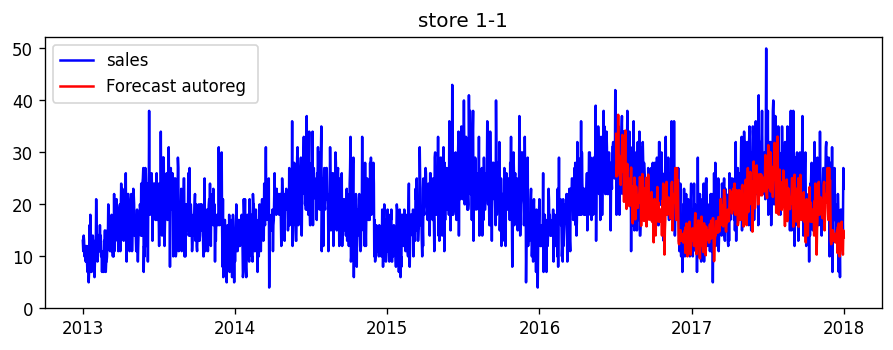

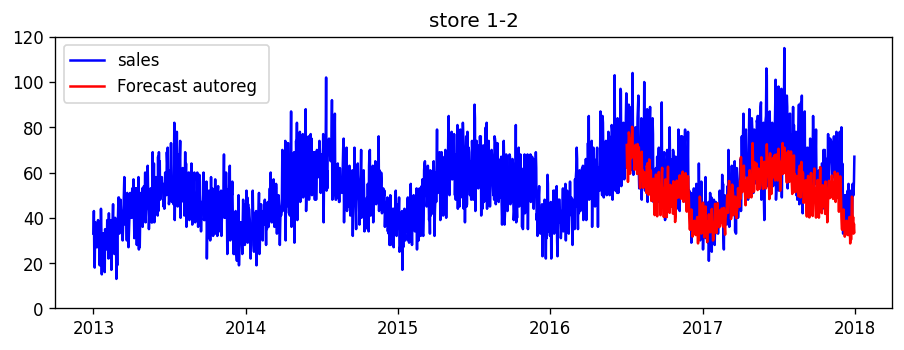

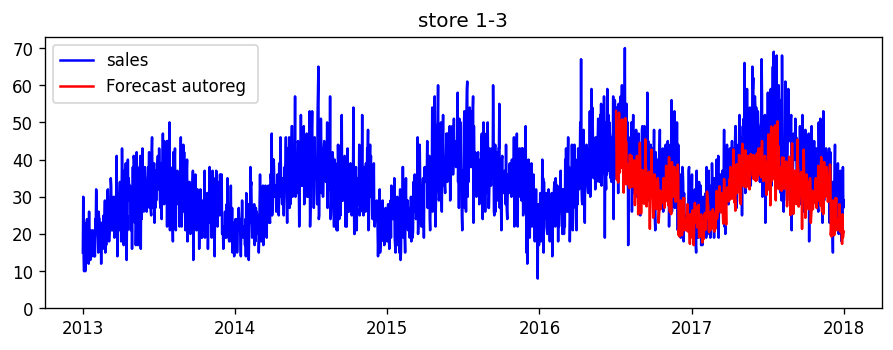

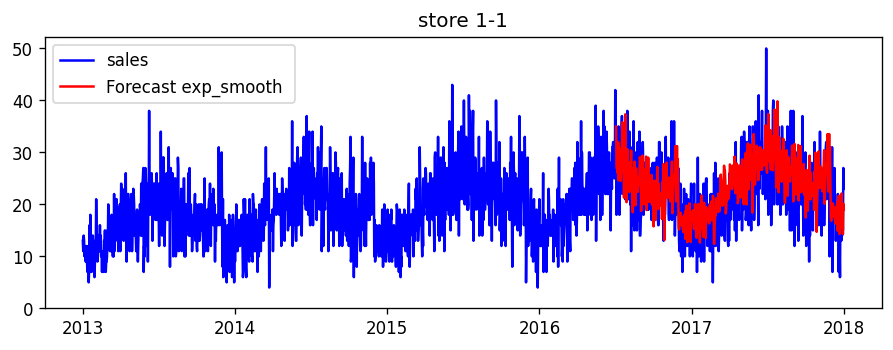

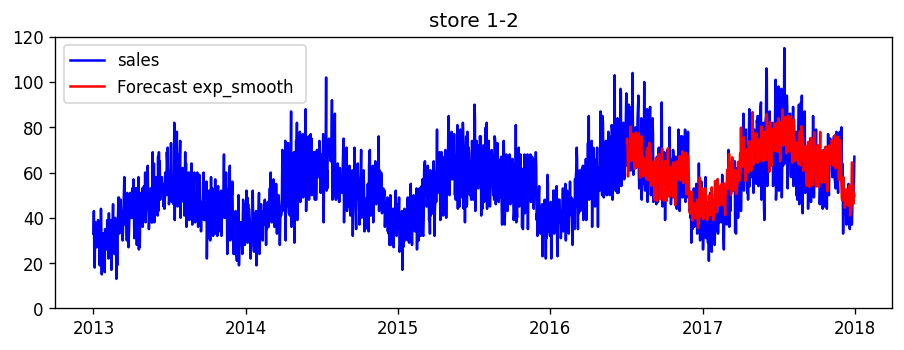

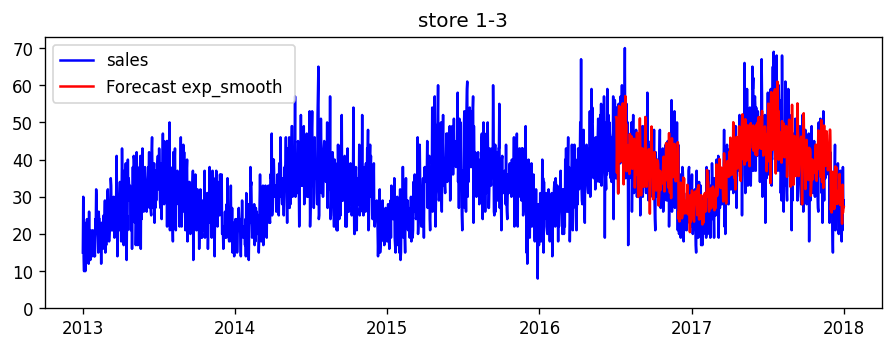

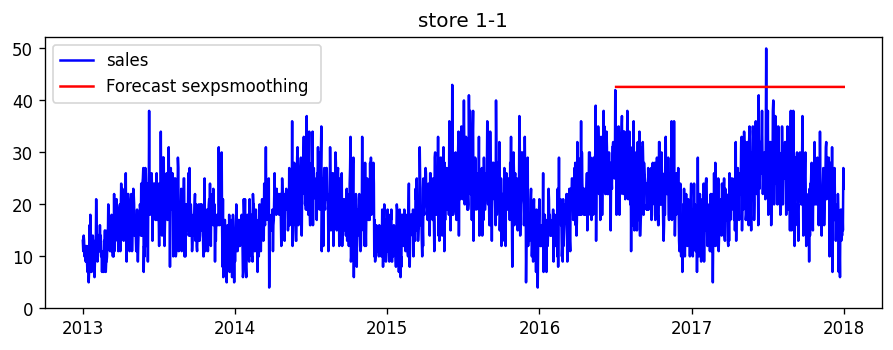

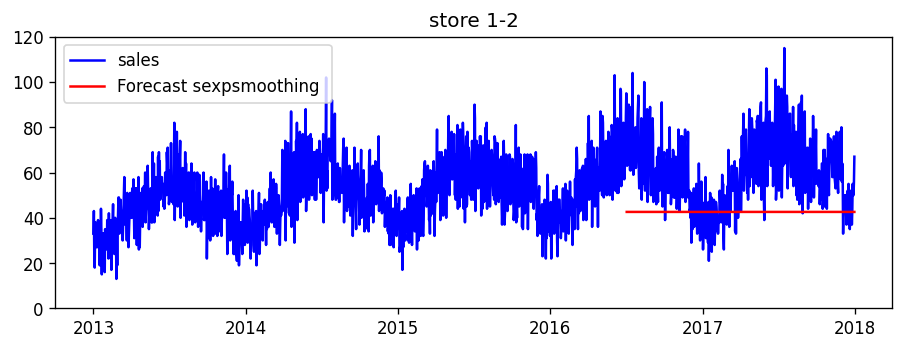

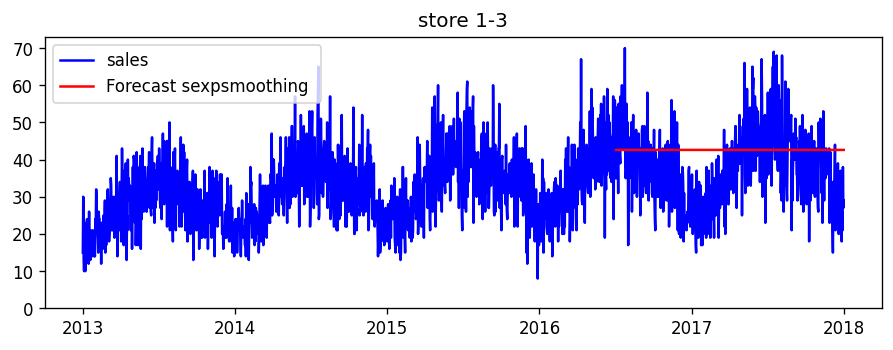

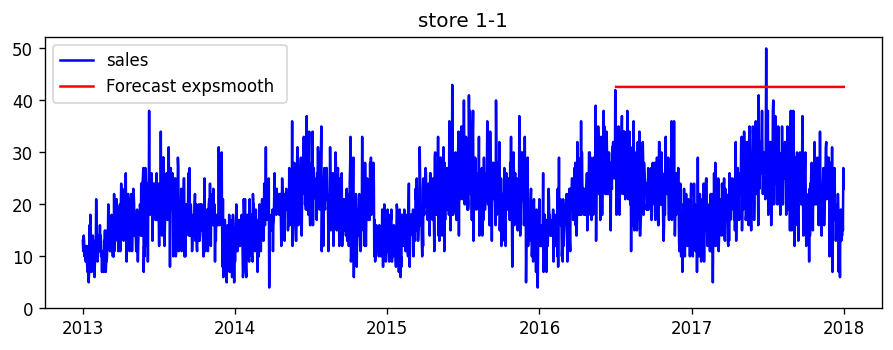

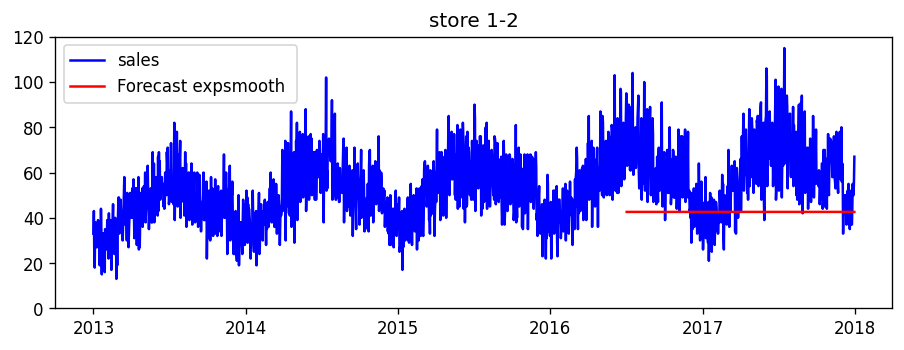

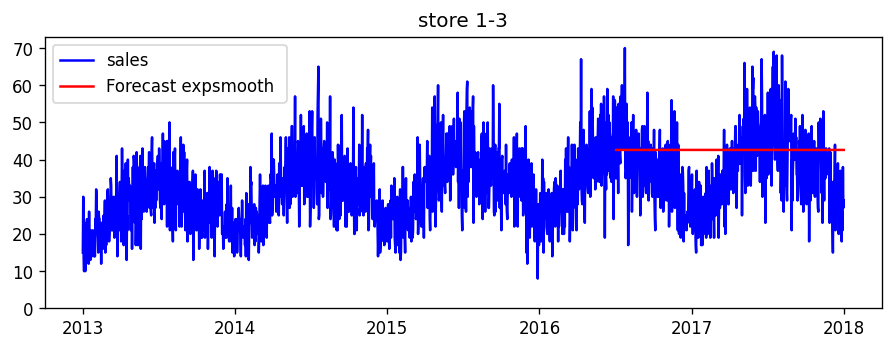

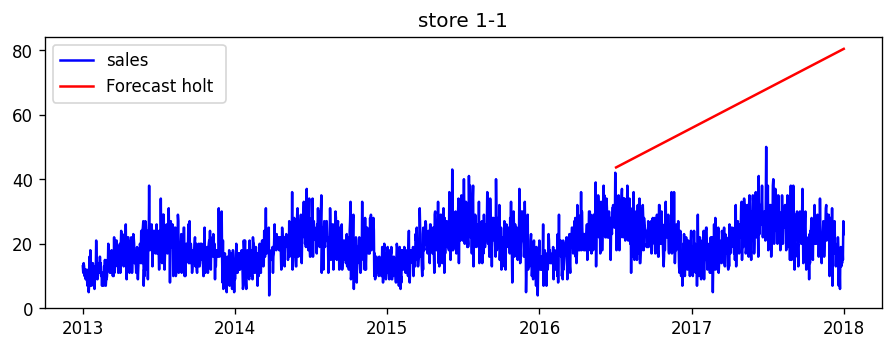

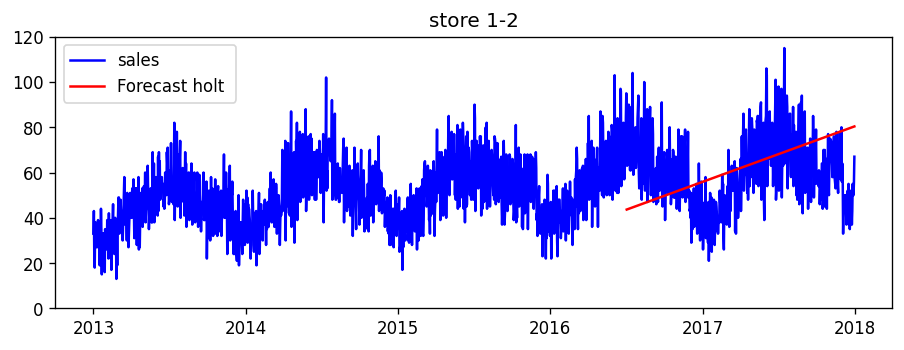

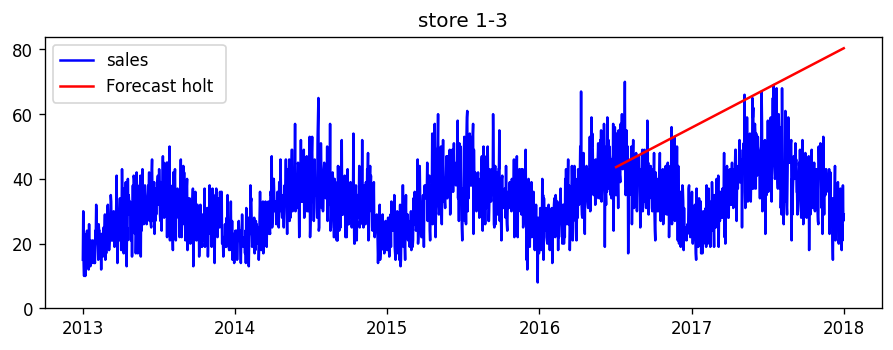

In [193]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

for forecast in store_sales.columns[2:]:
    fcastplotter(forecast)


In [191]:
from beepy import beep
beep()